# Chicago Real Estate Data Prediction Model

## 1. Introduction

The real estate market is a dynamic and complex domain, influenced by numerous factors such as property characteristics, location, and market trends. This project focuses on analyzing the **2024 Chicago real estate market** to predict property values and uncover the key factors driving property prices.

#### Goals:
- Develop a predictive model to estimate property prices with high accuracy.
- Identify and analyze key features that influence property values.
- Provide actionable insights for real estate stakeholders, including buyers, sellers, and investors.

#### Approach:
1. **Data Preprocessing**: Address missing values, remove irrelevant data, and transform features to ensure data quality.
2. **Feature Engineering**: Extract meaningful information from text fields, introduce interaction terms, and perform forward selection.
3. **Modeling**: Compare several regression models, including:
   - A baseline **OLS Regression model** (without preprocessing).
   - Regularized models like Lasso and Ridge Regression.
   - Robust regression techniques, such as **Huber Regression**, to handle outliers effectively.
5. **Evaluation**: Assess models using metrics like MSE and $R^2$, while ensuring statistical reliability through tests for multicollinearity, heteroskedasticity, and normality.

#### Dataset:
The dataset was sourced from Kaggle's **Real Estate Data Chicago 2024** and includes detailed information on property attributes such as size, type, and price. 

Dataset Link: https://www.kaggle.com/datasets/kanchana1990/real-estate-data-chicago-2024

## 2. Data Preprocessing

Key steps of data preprocessing include:

- **Dropping Rows**: Removed properties that could skew the analysis.
- **Handling Missing Values**: Addressed missing data to improve model reliability.
- **Transformations**: Applied log transformations to normalize skewed distributions.

In [344]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize

In [346]:
data = pd.read_csv("real_estate_data_chicago.csv")
data.head()

,type,text,year_built,beds,baths,baths_full,baths_half,garage,lot_sqft,sqft,stories,lastSoldPrice,soldOn,listPrice,status
0,single_family,"Come check out this amazing, move-in ready, 5 ...",1951.0,4.0,4.0,3.0,1.0,1.0,5615.0,3000.0,2.0,NaN,NaN,750000.0,for_sale
1,single_family,Move in ready 2 story Mount Greenwood home on ...,1922.0,4.0,3.0,2.0,1.0,2.0,6566.0,2900.0,2.0,105000.0,1991-04-16,499900.0,for_sale
2,single_family,Investor Special MONEY MAKING Gem. This is you...,1947.0,4.0,2.0,2.0,NaN,3.0,5375.0,1170.0,2.0,60000.0,2019-10-28,325600.0,for_sale
3,single_family,Renovated Brick 1.5 story house with finished ...,1945.0,4.0,3.0,2.0,1.0,2.0,6138.0,2511.0,2.0,170000.0,1996-05-30,620000.0,for_sale
4,single_family,This almost 3000sq foot home was thoughtfully ...,1907.0,4.0,4.0,2.0,2.0,2.0,8476.0,2870.0,3.0,NaN,NaN,850000.0,for_sale


In [348]:
print(data.shape)

(2000, 15)


In [350]:
# Prepare a DataFrame for data cleaning
data_clean = data.copy()

#### 2.1 Drop rows
Drop the property types labeled as 'land' (60 rows) or 'mobile' (2 rows), as they can be classified differently from the other property types in the dataset.

In [353]:
data_clean = data_clean[data_clean['type'] != 'land']
data_clean = data_clean[data_clean['type'] != 'mobile']

Drop null rows in 'listPrice', since it is the dependent variable.

In [356]:
data_clean = data_clean.dropna(subset=['listPrice'])

Drop null rows in 'sqft' as it directly influences the price

In [359]:
data_clean = data_clean.dropna(subset=['sqft'])

#### 2.2 Drop Columns
Drop 'lastSoldPrice' as prices fluctuate depending on the selling date, making it not directly comparable.

In [362]:
data_clean = data_clean.drop(['lastSoldPrice'], axis=1)

Drop 'baths' as this value is just the addition of 'baths_half' and 'baths_full'

In [365]:
data_clean = data_clean.drop(columns=['baths'])

'For-Sale' or 'Sold' are not necessary for the prediction

In [368]:
data_clean = data_clean.drop(columns=['status'])

#### 2.3 Fill in '0' for specific columns that naturally do not have data

In [371]:
data_clean["garage"] = data_clean["garage"].fillna(0)
data_clean["stories"] = data_clean["stories"].fillna(0)
data_clean["baths_half"] = data_clean["baths_half"].fillna(0)
data_clean["baths_full"] = data_clean["baths_full"].fillna(0)

#### 2.4 Fill in Missing Data of 'lot_sqft'
- Condos and apartments: Use its 'sqft' value
- Others (detached building): Use the mean ratio of lot_sqft/sqft

In [374]:
# Fill NaN values for 'condos' and 'apartment' types
data_clean.loc[data_clean['type'].isin(['condos', 'apartment']), 'lot_sqft'] = (
    data_clean.loc[data_clean['type'].isin(['condos', 'apartment']), 'lot_sqft']
    .fillna(data_clean['sqft'])
)

# Calculate the mean ratio of 'lot_sqft' to 'sqft'
ratio = data_clean['lot_sqft'].mean() / data_clean['sqft'].mean()

# Fill NaN values for all other types using the mean ratio
data_clean.loc[~data_clean['type'].isin(['condos', 'apartment']), 'lot_sqft'] = (
    data_clean.loc[~data_clean['type'].isin(['condos', 'apartment']), 'lot_sqft']
    .fillna(data_clean['sqft'] * ratio)
)

#### 2.5 Data Conversion
Convert 'year_built' into the age of houses in 2024

In [377]:
data_clean['age'] = 2024 - data_clean['year_built']
data_clean.drop(columns=['year_built'], inplace=True)
data_clean['age'] = data_clean['age'].fillna(data_clean['age'].mean())

Calculate the time elapsed from 'soldOn' to 2024

In [380]:
data_clean['time_to_last_sold'] = 2024 - pd.to_datetime(data_clean['soldOn']).dt.year
data_clean.drop(columns=['soldOn'], inplace=True)
data_clean['time_to_last_sold'] = data_clean['time_to_last_sold'].fillna(data_clean['time_to_last_sold'].mean())
data_clean['time_to_last_sold'] = data_clean['time_to_last_sold'].astype(int)

## 3. Text-Data Mapping
The 'text' column contains information that could influence housing prices. This section aims to extract data from the text that is not included in the existing columns but may impact the dependent variable.

#### 3.1 Create Binary Dummy Variables Indicating Whether 'Living Room,' 'Kitchen,' and 'Basement' Are Mentioned
The terms **living room**, **kitchen**, and **basement** are mentioned in the text in $34.6%$, $30.4%$, and $34.2%$ of listings, respectively.

- Listings mentioning a **living room** have a higher mean list price (661K) compared to those without (513K). $P-value: 0.0056$
- Listings mentioning a **kitchen** have a significantly higher mean list price (648K) compared to those without (372K). $P-value: 0.0000$
- Listings mentioning a **basement** have a lower mean list price (446K) compared to those without (626K). $P-value: 0.0000$

Therefore, due to their potential influence on housing prices, dummy variables were created to indicate whether the property description includes these keywords.

In [383]:
data_clean.loc[:,"livingR_text"] = pd.DataFrame(data_clean["text"].str.lower())["text"].str.contains("living room").fillna(False).astype(int)
data_clean.loc[:,"kitchen_text"] = pd.DataFrame(data_clean["text"].str.lower())["text"].str.contains("kitchen").fillna(False).astype(int)
data_clean.loc[:,"basement_text"] = pd.DataFrame(data_clean["text"].str.lower())["text"].str.contains("basement").fillna(False).astype(int)
data_clean.head(3)

/var/folders/zr/hq5f8g3s0jq6yt_pl2ppbgmc0000gn/T/ipykernel_33315/946131957.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_clean.loc[:,"livingR_text"] = pd.DataFrame(data_clean["text"].str.lower())["text"].str.contains("living room").fillna(False).astype(int)
/var/folders/zr/hq5f8g3s0jq6yt_pl2ppbgmc0000gn/T/ipykernel_33315/946131957.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_clean.loc[:,"kitchen_text"] = pd.DataFrame(data_clean["text"].str.lower())["text"].str.contains("kitchen").fillna(False).astype(int)
/var/folders/zr/hq5f8g3s0j

,type,text,beds,baths_full,baths_half,garage,lot_sqft,sqft,stories,listPrice,age,time_to_last_sold,livingR_text,kitchen_text,basement_text
0,single_family,"Come check out this amazing, move-in ready, 5 ...",4.0,3.0,1.0,1.0,5615.0,3000.0,2.0,750000.0,73.0,14,1,1,1
1,single_family,Move in ready 2 story Mount Greenwood home on ...,4.0,2.0,1.0,2.0,6566.0,2900.0,2.0,499900.0,102.0,33,0,1,1
2,single_family,Investor Special MONEY MAKING Gem. This is you...,4.0,2.0,0.0,3.0,5375.0,1170.0,2.0,325600.0,77.0,5,0,1,1


#### 3.2 Create Categorical Variables for Floor Types
The material preceding the word *floor* in property descriptions was identified to create dummy variables for floor types. The materials were categorized into three price tiers—**budget**, **mid-priced**, and **expensive**—based on their typical market value. The classification and corresponding mean list prices are as follows:

- **Budget**: Includes materials such as *wood, laminate, tile, vinyl, and plank* with a mean list price of **470K**.  
- **Mid-Priced**: Includes materials such as *oakwood, hardwood, limestone, ceramic, terracotta, and parquet* with a mean list price of **542K**.  
- **Expensive**: Includes materials such as *mahogany, walnut, cherry, cherrywood, maple, marble, granite, and terrazzo* with a mean list price of **2,020K**.  

In [386]:
def floor_material(text_row):
    if pd.isna(text_row):
        return "unknownOrNan"
    expensive = ["mahogany", "walnut", "cherry", "cherrywood", "maple", "marble", "granite", "terrazzo"]
    mid_price = ["oakwood", "hardwood", "limestone", "ceramic", "terracotta", "parquet"]
    budget = ["wood", "laminate", "tile", "vinyl", "plank"]
    tokens = word_tokenize(text_row)
    for i in range(len(tokens)):
        if tokens[i].find("floor") >= 0:
            previous_word = tokens[i - 1]
            if previous_word in expensive:
                return "expensive"
            elif previous_word in mid_price:
                return "mid_price"
            elif previous_word in budget:
                return "budget"
            else:
                return "unknownOrNan"
    return "unknownOrNan"

# Apply the function and count the categories
data_clean.loc[:,"floor_text"]=data_clean["text"].apply(floor_material)
data_clean.head(3)

,type,text,beds,baths_full,baths_half,garage,lot_sqft,sqft,stories,listPrice,age,time_to_last_sold,livingR_text,kitchen_text,basement_text,floor_text
0,single_family,"Come check out this amazing, move-in ready, 5 ...",4.0,3.0,1.0,1.0,5615.0,3000.0,2.0,750000.0,73.0,14,1,1,1,mid_price
1,single_family,Move in ready 2 story Mount Greenwood home on ...,4.0,2.0,1.0,2.0,6566.0,2900.0,2.0,499900.0,102.0,33,0,1,1,unknownOrNan
2,single_family,Investor Special MONEY MAKING Gem. This is you...,4.0,2.0,0.0,3.0,5375.0,1170.0,2.0,325600.0,77.0,5,0,1,1,unknownOrNan


In [387]:
data_clean.drop(columns=['text'], inplace=True)

Check for null values to finalize the data cleaning process

In [391]:
print(data_clean.isnull().sum().sort_values(ascending=False))
data_clean.head(4)

# Convert to csv file
data_clean.to_csv("final_clean.csv", index=False)

type                 0
beds                 0
baths_full           0
baths_half           0
garage               0
lot_sqft             0
sqft                 0
stories              0
listPrice            0
age                  0
time_to_last_sold    0
livingR_text         0
kitchen_text         0
basement_text        0
floor_text           0
dtype: int64


All null values have been cleared.

## 4. Exploratory Data Analysis (EDA)
#### 4.1 Distribution Plots
Investigate skewed distributions and apply log transformations to those variables.

In [394]:
# Add dummy variables for 'type' and 'floor_text'
data_model = pd.get_dummies(data_clean, columns=['type', 'floor_text'])

In [396]:
# Split X, y variables
X = data_model.drop(columns=["listPrice"])
y = data_model["listPrice"]

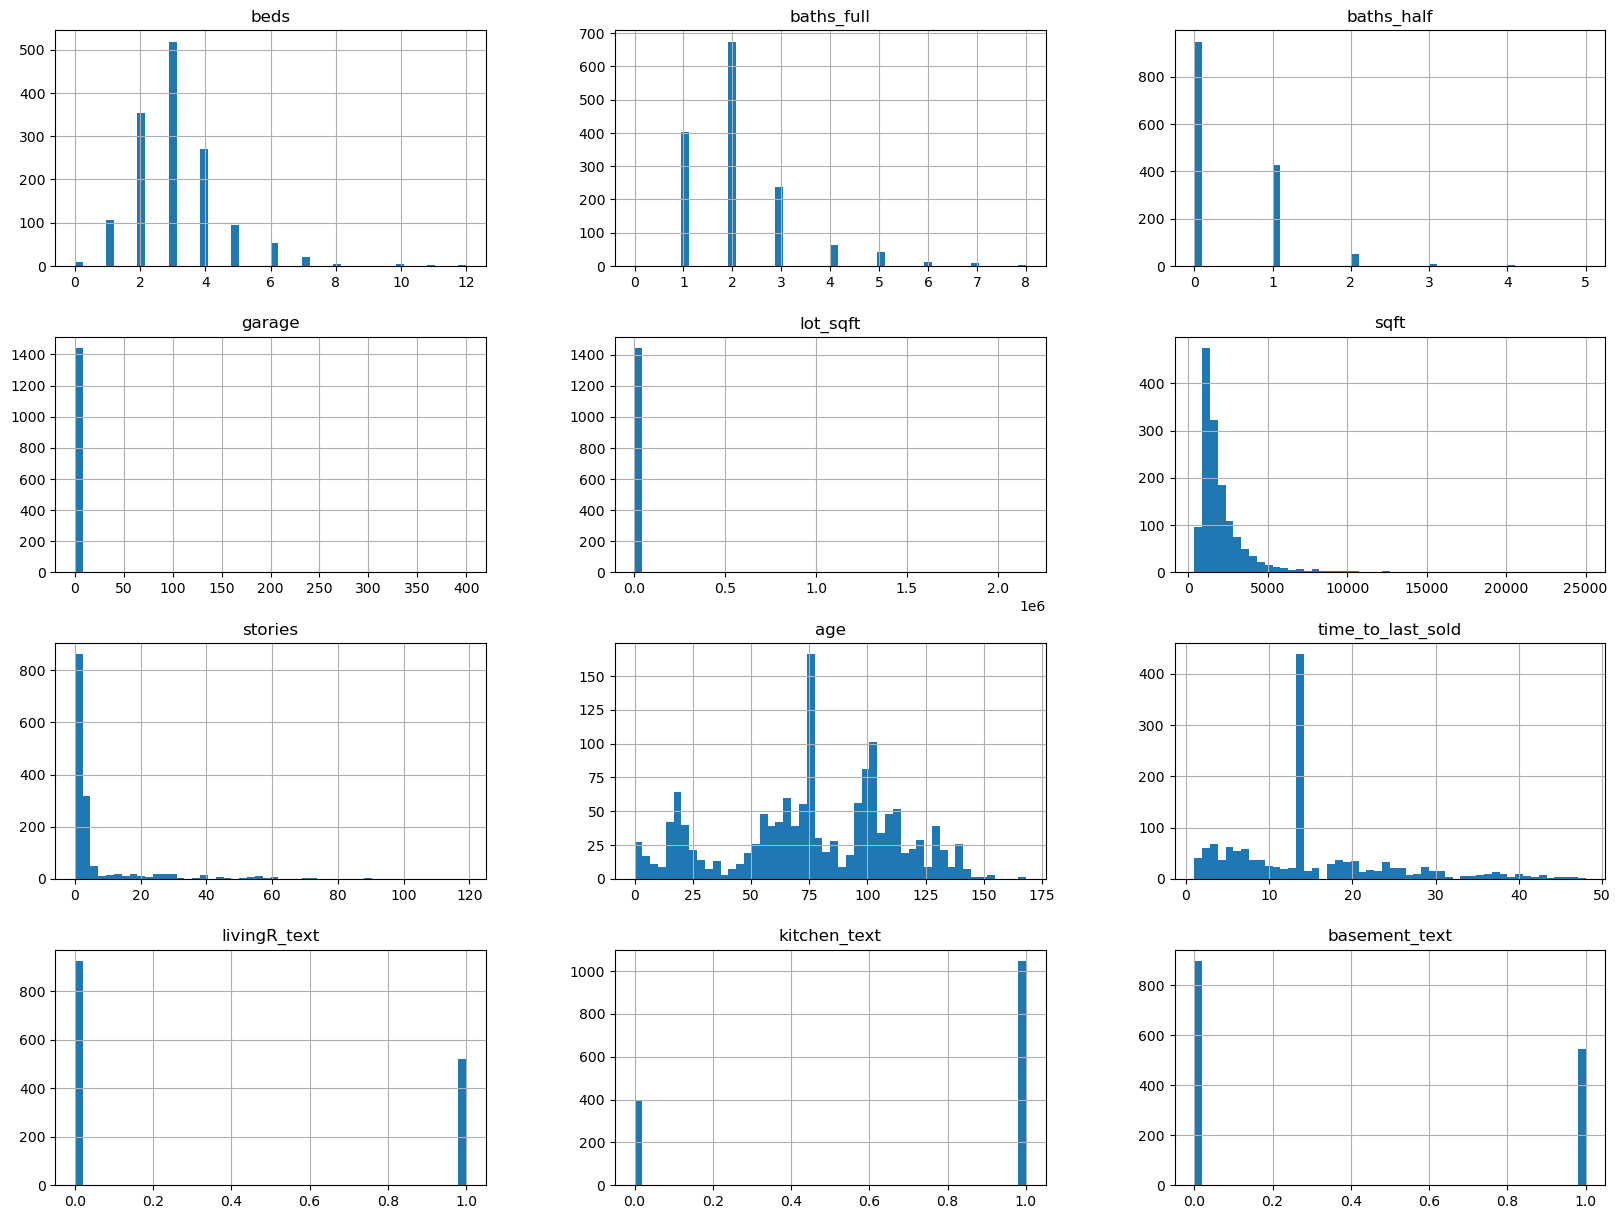

In [398]:
# Plot the distribution of all variables
import matplotlib.pyplot as plt

X.hist(bins=50, figsize=(20,15))
plt.show()

Distribution of 'sqft', 'stories', 'lot_sqft', and 'garage' are skewed.

Perform log transformation for skewed variables:

In [400]:
# Log-Transform Independent Variables
X["log_sqft"] = np.log(X["sqft"])
X["log_stories"] = np.log(X["stories"] + 1)
X["log_lot_sqft"] = np.log(X["lot_sqft"])
X["log_garage"] = np.log(X["garage"] + 1)

In [403]:
# Log-Transform Dependent Variable
y = np.log(data_model["listPrice"])

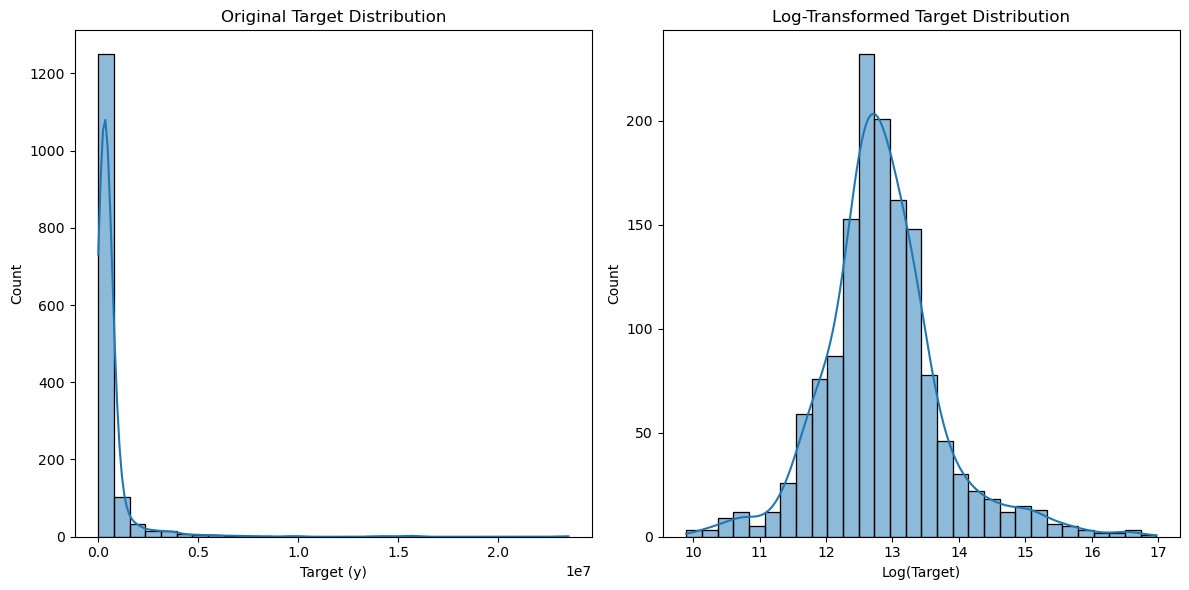

In [405]:
# Plot the change in target distribution
import seaborn as sns
import numpy as np

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data_model["listPrice"], kde=True, bins=30)
plt.title("Original Target Distribution")
plt.xlabel("Target (y)")

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(data_model["listPrice"]), kde=True, bins=30)
plt.title("Log-Transformed Target Distribution")
plt.xlabel("Log(Target)")

plt.tight_layout()
plt.show()

#### 4.2 Relationship Analysis: List Price vs Square Footage, Age, Beds

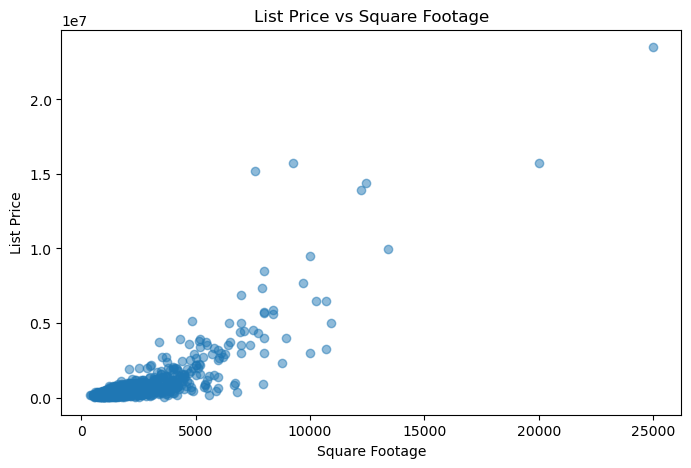

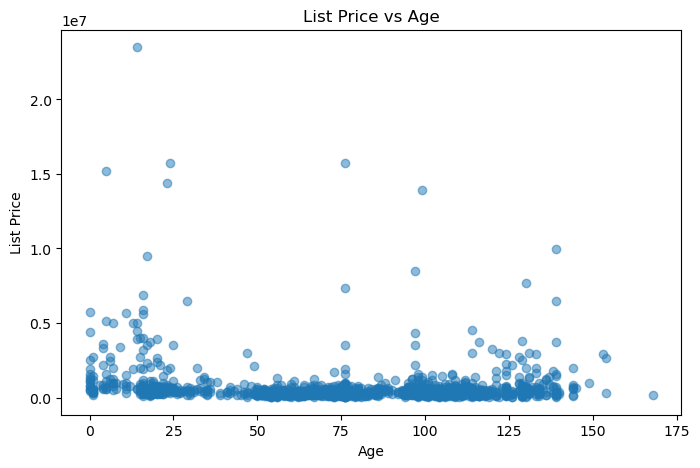

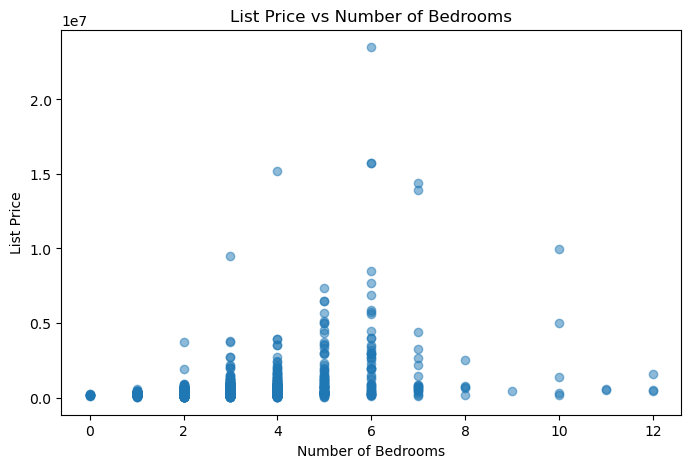

In [408]:
plt.figure(figsize=(8, 5))
plt.scatter(data_model['sqft'], data_model['listPrice'], alpha=0.5)
plt.title('List Price vs Square Footage')
plt.xlabel('Square Footage')
plt.ylabel('List Price')
plt.grid(False)
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(data_model['age'], data_model['listPrice'], alpha=0.5)
plt.title('List Price vs Age')
plt.xlabel('Age')
plt.ylabel('List Price')
plt.grid(False)
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(data_model['beds'], data_model['listPrice'], alpha=0.5)
plt.title('List Price vs Number of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('List Price')
plt.grid(False)
plt.show()

#### 4.3 Correlation Analysis of Numerical Features
The strongest positive correlations with listPrice are:

- sqft (0.82): Larger homes are priced higher.
- beds (0.34): More bathrooms are associated with higher prices.
  
Other features like garage, lot_sqft, and stories show minimal or no significant correlation with listPrice.

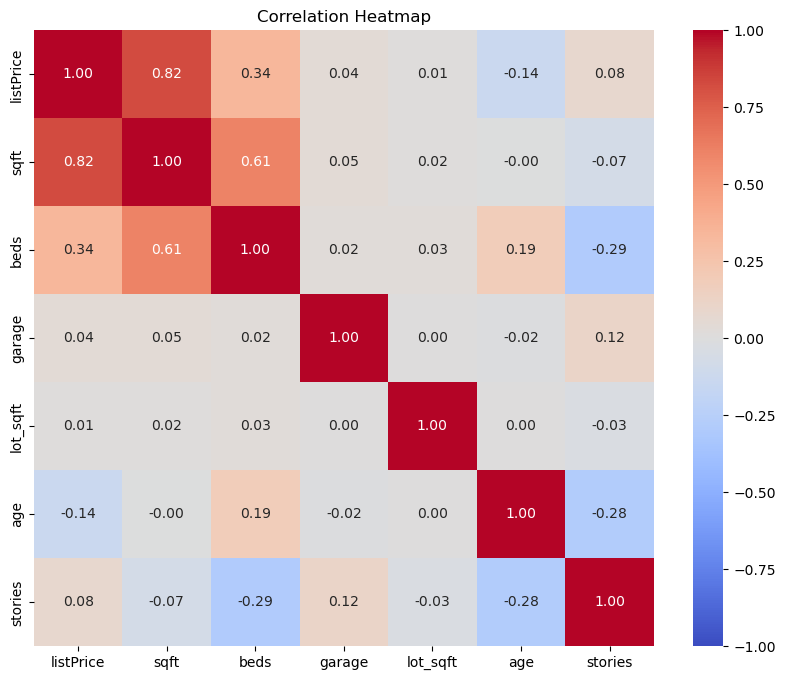

listPrice    1.000000
sqft         0.823902
beds         0.342806
stories      0.082515
garage       0.040328
lot_sqft     0.011360
age         -0.135821
Name: listPrice, dtype: float64

In [411]:
numerical_columns = ['listPrice', 'sqft', 'beds', 'garage', 'lot_sqft', 'age', 'stories']
correlation_matrix = data_model[numerical_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

list_price_correlations = correlation_matrix['listPrice'].sort_values(ascending=False)
list_price_correlations

#### 4.4 Time Trends for Properties Sold

/var/folders/zr/hq5f8g3s0jq6yt_pl2ppbgmc0000gn/T/ipykernel_33315/4116126329.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sold['sold_year'] = df_sold['soldOn'].dt.year
/var/folders/zr/hq5f8g3s0jq6yt_pl2ppbgmc0000gn/T/ipykernel_33315/4116126329.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_sold, x='sold_year', y='listPrice', ci=None)


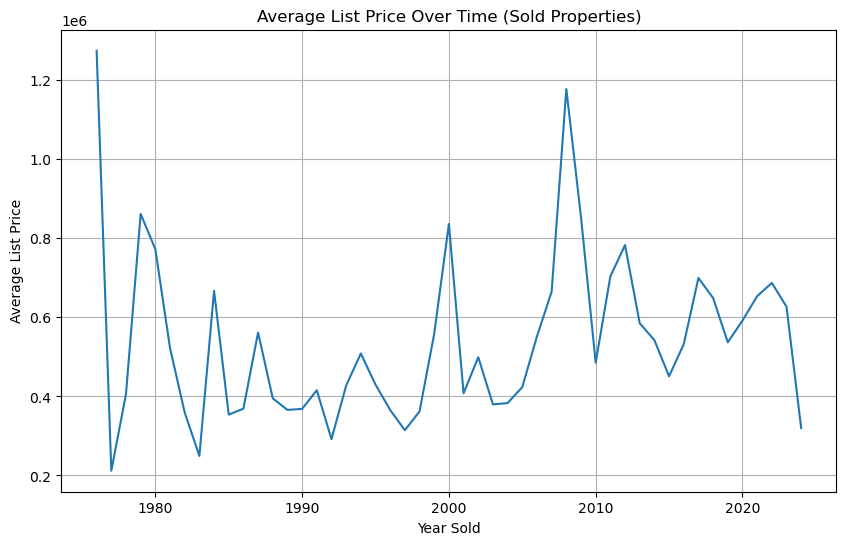

In [414]:
if not pd.api.types.is_datetime64_any_dtype(data['soldOn']):
    data['soldOn'] = pd.to_datetime(data['soldOn'], errors='coerce')

df_sold = data.dropna(subset=['soldOn', 'listPrice'])
df_sold['sold_year'] = df_sold['soldOn'].dt.year

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_sold, x='sold_year', y='listPrice', ci=None)
plt.title('Average List Price Over Time (Sold Properties)')
plt.xlabel('Year Sold')
plt.ylabel('Average List Price')
plt.grid(True)
plt.show()

#### 4.5 Average List Price by Age

/var/folders/zr/hq5f8g3s0jq6yt_pl2ppbgmc0000gn/T/ipykernel_33315/1465843530.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_price_by_adjusted_bins = data_model.groupby(year_built_bins_adjusted)['listPrice'].mean()


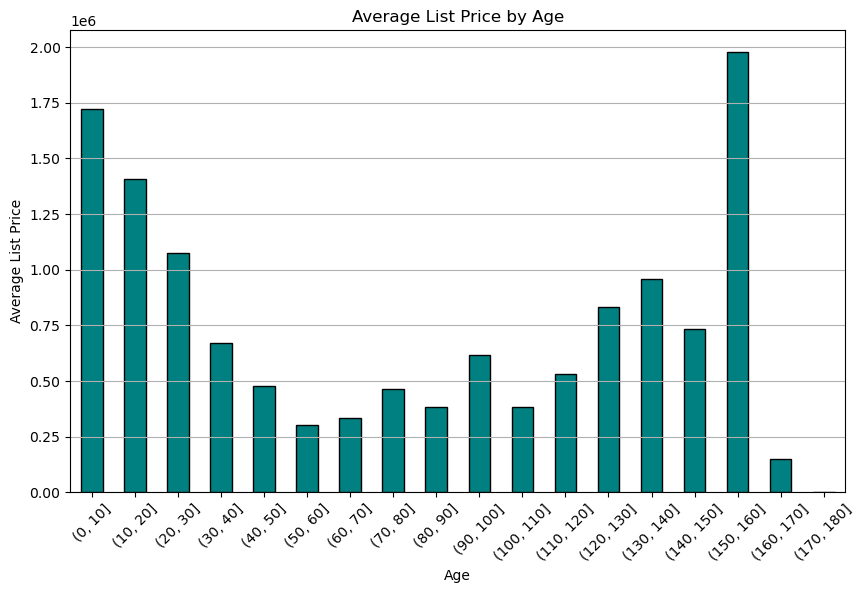

In [417]:
bins = range(int(data_model['age'].min()), int(data_model['age'].max()) + 20, 10)
year_built_bins_adjusted = pd.cut(data_model['age'].dropna(), bins=bins)
avg_price_by_adjusted_bins = data_model.groupby(year_built_bins_adjusted)['listPrice'].mean()

plt.figure(figsize=(10, 6))
avg_price_by_adjusted_bins.plot(kind='bar', color='teal', edgecolor='black')
plt.title('Average List Price by Age')
plt.xlabel('Age')
plt.ylabel('Average List Price')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

#### 4.6 Average List Price by Number of Garages

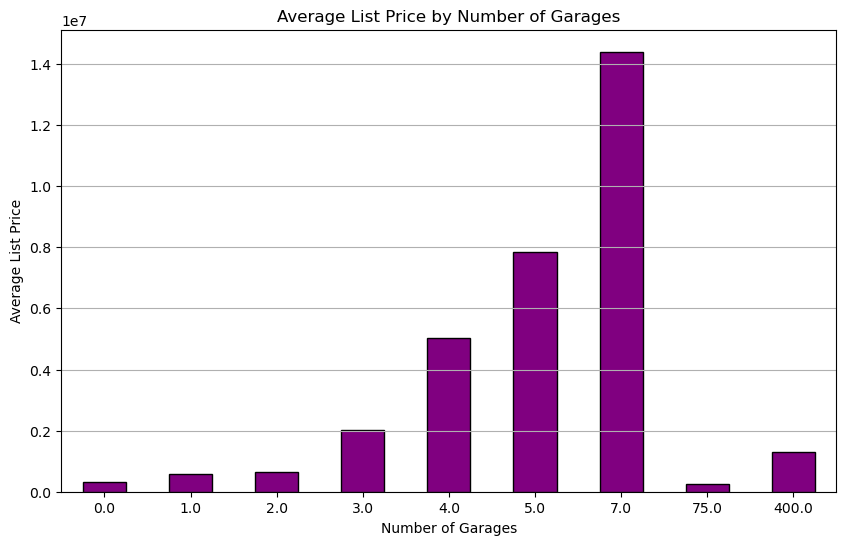

In [420]:
avg_price_by_garages = data_model.groupby('garage')['listPrice'].mean()

plt.figure(figsize=(10, 6))
avg_price_by_garages.plot(kind='bar', color='purple', edgecolor='black')
plt.title('Average List Price by Number of Garages')
plt.xlabel('Number of Garages')
plt.ylabel('Average List Price')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

#### 4.7 Average List Price by Number of Bedrooms

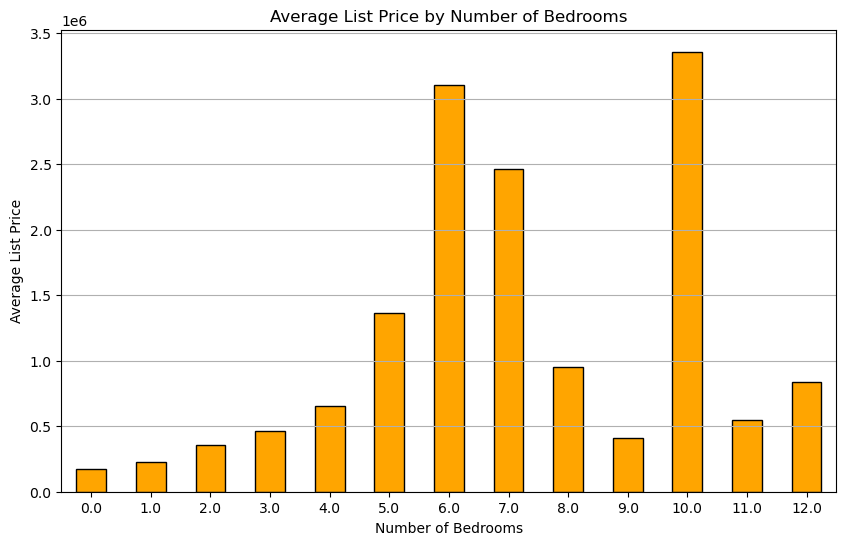

In [423]:
avg_price_by_bedrooms = data_model.groupby('beds')['listPrice'].mean()

plt.figure(figsize=(10, 6))
avg_price_by_bedrooms.plot(kind='bar', color='orange', edgecolor='black')
plt.title('Average List Price by Number of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Average List Price')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

#### 4.8 Average List Price by Number of Bathrooms

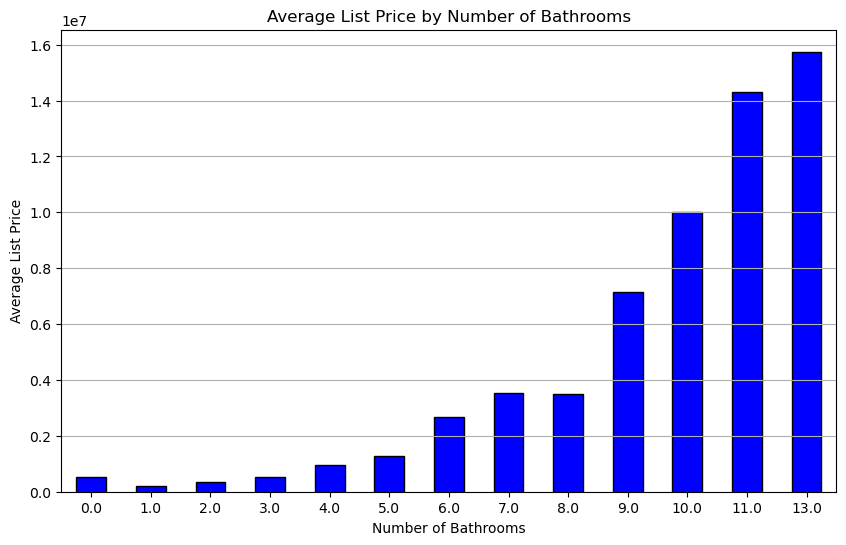

In [426]:
avg_price_by_bathrooms = data.groupby('baths')['listPrice'].mean()

plt.figure(figsize=(10, 6))
avg_price_by_bathrooms.plot(kind='bar', color='blue', edgecolor='black')
plt.title('Average List Price by Number of Bathrooms')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Average List Price')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

#### 4.9 Relationship Between List Price and Square Footage (Outliers Removed)

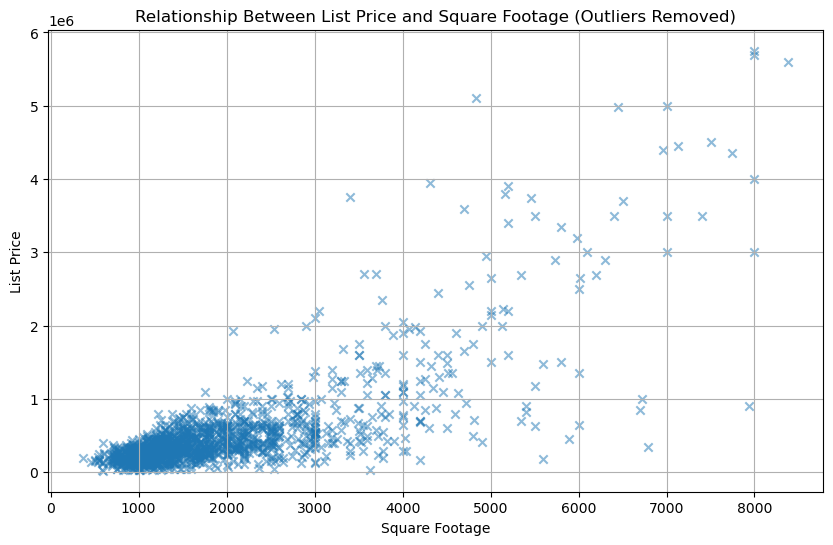

In [429]:
sqft_threshold = data_model['sqft'].quantile(0.99)
price_threshold = data_model['listPrice'].quantile(0.99)

df_filtered = data_model[(data_model['sqft'] <= sqft_threshold) & (data_model['listPrice'] <= price_threshold)]

plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['sqft'], df_filtered['listPrice'], marker='x', alpha=0.5)
plt.title('Relationship Between List Price and Square Footage (Outliers Removed)')
plt.xlabel('Square Footage')
plt.ylabel('List Price')
plt.grid(True)
plt.show()

#### 4.10 Average List Price by Number of Stories

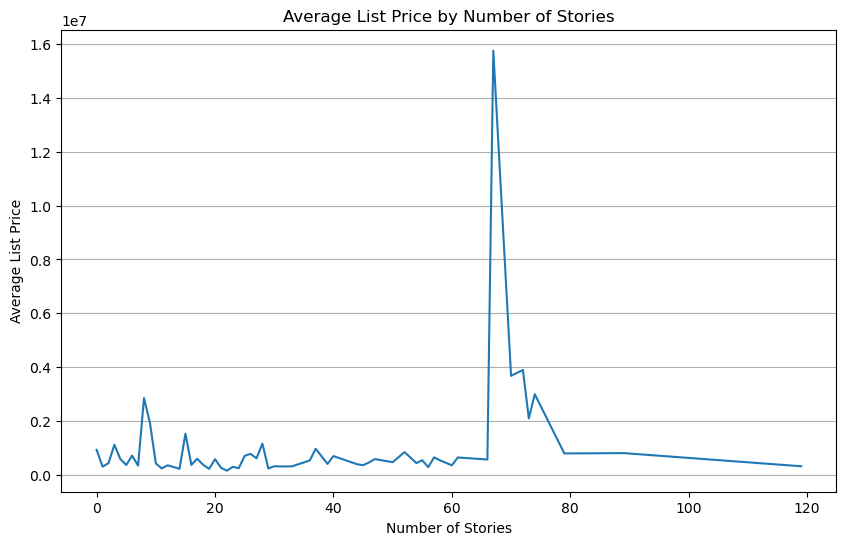

In [432]:
avg_price_by_stories = data_model.groupby('stories')['listPrice'].mean()

plt.figure(figsize=(10, 6))
avg_price_by_stories.plot(kind='line')
plt.title('Average List Price by Number of Stories')
plt.xlabel('Number of Stories')
plt.ylabel('Average List Price')

plt.grid(axis='y')
plt.show()

#### 4.11 Average List Price by Property Type

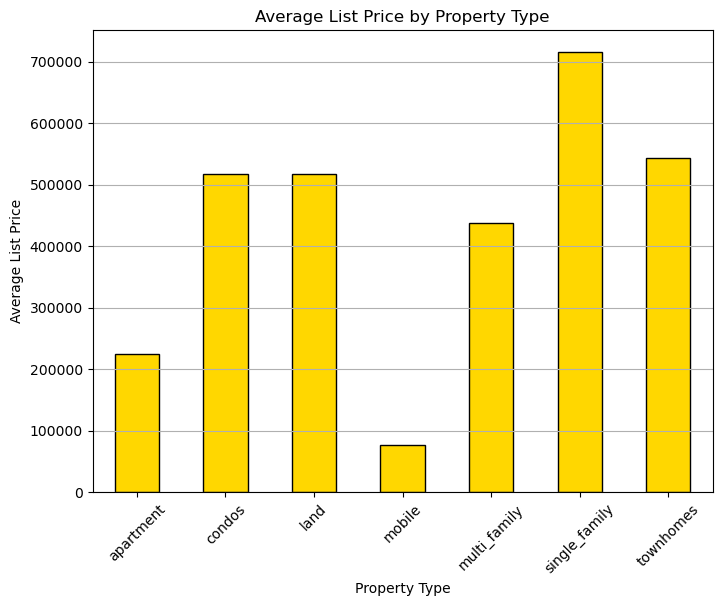

In [435]:
avg_price_by_type = data.groupby('type')['listPrice'].mean()

plt.figure(figsize=(8, 6))
avg_price_by_type.plot(kind='bar', color='gold', edgecolor='black')
plt.title('Average List Price by Property Type')
plt.xlabel('Property Type')
plt.ylabel('Average List Price')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

## 5. Interaction Terms
Add second-order interaction terms. Useful terms will be selected later during the forward selection process.

In [441]:
from itertools import combinations

def add_interaction_terms(df):
    features = df.columns
    interaction_data = {}
    for feature1, feature2 in combinations(features, 2):
        interaction_term = f"{feature1}*{feature2}"
        interaction_data[interaction_term] = df[feature1] * df[feature2]

    # Concatenate the original DataFrame with the new interaction terms
    interaction_df = pd.concat([df, pd.DataFrame(interaction_data)], axis=1)
    return interaction_df


X_interactions = add_interaction_terms(X)
X_interactions = X_interactions.drop(columns=X_interactions.columns[X_interactions.nunique() == 1])

## 6. Feature Selection
Perform Forward Feature Selection to identify the best subset for the model.

In [444]:
# Split the data into training and testing sets (8:2)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_interactions, X_test_interactions= train_test_split(X_interactions, test_size=0.2, random_state=42)

In [446]:
# Normalize the X: not necessary for linear regression, but useful for interpretation after
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_interactions)
X_test_scaled = scaler.transform(X_test_interactions)

X_train_interactions= pd.DataFrame(X_train_scaled, columns=X_train_interactions.columns)
X_test_interactions = pd.DataFrame(X_test_scaled, columns=X_train_interactions.columns)

In [448]:
# Forward Feature Selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

# Define adjusted R^2 function
def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)

# Sequential Forward Selection using 5-fold cross-validation
def forward_selection_with_cv(model, X_train, y_train, target_num_features):
    # Define the feature selection process
    sfs = SFS(
        model,
        k_features=target_num_features,
        forward=True,
        floating=False,
        scoring="r2",
        cv=4,  # 4-fold cross-validation
        n_jobs=-1,
    )

    # Fit SFS on the training data
    sfs.fit(X_train, y_train)

    # Get the selected feature indices and names
    selected_indices = list(sfs.k_feature_idx_)
    selected_features = X_train.columns[selected_indices]

    # Retrieve the best CV score from SFS
    best_r2 = sfs.k_score_
    n = X_train.shape[0]  # Number of samples
    k = len(selected_features)  # Number of selected features
    adj_r2 = adjusted_r2(best_r2, n, k)

    print(f"Selected Features: {selected_features}")
    print(f"Best CV R^2: {best_r2}")
    print(f"Adjusted R^2: {adj_r2}")

    return selected_features, adj_r2

Data pre-processing is complete.

## 7. Modeling

To determine the best predictive model, various linear regression techniques were tested, including OLS Linear Regression (with and without pre-processing) and Robust Linear Regression Models:

- Baseline OLS Linear Regression Without Preprocessing
- OLS Linear Regression After Preprocessing
- Lasso Regression
- Ridge Regression
- Huber Regression

The Huber Regression model demonstrated the best performance, with a **33.18%** improvement in $R^2$ and **32.71%** improvement in Adjusted $R^2$ compared to the baseline.

#### 7.1 Baseline Model: OLS Regression (Without Pre-Processing)
We fit a baseline OLS regression model using the raw dataset, before implementing feature engineering and text-data mapping. This model serves as a benchmark to evaluate the impact of data preprocessing and advanced modeling techniques on prediction performance.

- The OLS model is trained directly on the unprocessed features. 
- No transformations, interaction terms, or dummy variables are included. (String variables are removed)
- The performance metrics (MSE, MAE, $R^2$, and Adjusted $R^2$ from this baseline model will be compared to the final robust linear regression model to highlight the improvements achieved through preprocessing, feature engineering, and model selection.

In [452]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_raw = data_clean.drop(columns=['listPrice', 'type', 'livingR_text', 'kitchen_text', 'basement_text', 'floor_text']) 
y_raw = data_clean['listPrice']

from sklearn.model_selection import train_test_split
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)

ols_baseline = LinearRegression()
ols_baseline.fit(X_train_raw, y_train_raw)

y_pred_raw = ols_baseline.predict(X_test_raw)

mse_raw = mean_squared_error(y_test_raw, y_pred_raw)
mae_raw = mean_absolute_error(y_test_raw, y_pred_raw)
r2_raw = r2_score(y_test_raw, y_pred_raw)
adj_r2_raw = 1 - (1 - r2_raw) * (len(y_test_raw) - 1) / (len(y_test_raw) - X_test_raw.shape[1] - 1)

print("Baseline OLS Regression Performance (No Pre-Processing):")
print(f"Mean Squared Error (MSE): {mse_raw:.4f}")
print(f"Mean Absolute Error (MAE): {mae_raw:.4f}")
print(f"R²: {r2_raw:.4f}")
print(f"Adjusted R²: {adj_r2_raw:.4f}")

Baseline OLS Regression Performance (No Pre-Processing):
Mean Squared Error (MSE): 623761136340.0226
Mean Absolute Error (MAE): 380299.0125
R²: 0.5618
Adjusted R²: 0.5477


#### 7.2 OLS Linear Regression (After Pre-Processing)

$$
\hat{\beta} = \underset{\beta}{\arg\min} \sum_{i=1}^{n} \left( y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij} \right)^2
$$

Where:
- $ y_i $: Observed target value.
- $ x_{ij} $: Feature value for observation \(i\) and feature \(j\).
- $ \beta_0 $: Intercept term.
- $ \beta_j $: Coefficients of the features.

In [455]:
model = LinearRegression()

selected_features, final_adjusted_r2 = forward_selection_with_cv(
    model, X_train_interactions, y_train, 16
)

model = LinearRegression()
model.fit(X_train_interactions[selected_features], y_train)

y_pred = model.predict(X_test_interactions[selected_features])
r2_log = r2_score((y_test).values, y_pred)
r2 = r2_score(np.exp(y_test).values, np.exp(y_pred))
print(f"Linear Regression - R2 on test log: {r2_log}")
print(f"Linear Regression - R2 on test: {r2}")

Selected Features: Index(['stories', 'log_sqft', 'log_garage', 'baths_full*baths_half',
       'baths_full*kitchen_text', 'baths_full*type_single_family',
       'baths_full*type_townhomes', 'baths_full*log_sqft',
       'baths_half*log_sqft', 'age*kitchen_text', 'age*log_stories',
       'time_to_last_sold*type_condos', 'type_condos*log_sqft',
       'type_condos*log_stories', 'type_single_family*log_garage',
       'log_sqft*log_garage'],
      dtype='object')
Best CV R^2: 0.7274147614167659
Adjusted R^2: 0.7235822800307099
Linear Regression - R2 on test log: 0.648038217021522
Linear Regression - R2 on test: 0.6896546781862944


#### 7.3 Lasso Regression
**Lasso Regression** adds an \(L_1\)-regularization term to the Linear Regression objective:

$$
\hat{\beta} = \underset{\beta}{\arg\min} \left[ \sum_{i=1}^{n} \left( y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij} \right)^2 + \lambda \sum_{j=1}^{p} |\beta_j| \right]
$$

Where:
- $ \lambda $: Regularization parameter controlling the strength of the penalty.
- $ \sum_{j=1}^{p} |\beta_j| $: Lasso penalty (sum of absolute values of coefficients).


In [457]:
from sklearn.linear_model import Lasso

model = Lasso(alpha=0.01)
selected_features, final_adjusted_r2 = forward_selection_with_cv(
    model, X_train_interactions, y_train, 16
)

model_lasso = Lasso(alpha=0.01)  # Adjust alpha as needed
model_lasso.fit(X_train_interactions[selected_features], y_train)

# Predictions for test set
y_pred_lasso = model_lasso.predict(X_test_interactions[selected_features])
r2_log_lasso = r2_score(y_test, y_pred_lasso)
y_pred_exp_lasso = np.exp(y_pred_lasso)
r2_lasso = r2_score(np.exp(y_test), y_pred_exp_lasso)

# Output Lasso Regression R^2
print(f"Lasso Regression - R2 on test log: {r2_log_lasso}")
print(f"Lasso Regression - R2 on test: {r2_lasso}")

Selected Features: Index(['baths_full', 'type_condos', 'log_sqft', 'log_garage',
       'baths_full*baths_half', 'baths_full*kitchen_text',
       'baths_full*type_multi_family', 'baths_half*log_sqft',
       'sqft*kitchen_text', 'sqft*type_multi_family',
       'stories*floor_text_budget', 'stories*log_stories', 'age*log_stories',
       'time_to_last_sold*type_condos', 'kitchen_text*log_sqft',
       'type_condos*log_stories'],
      dtype='object')
Best CV R^2: 0.7219944905282585
Adjusted R^2: 0.7180858014671443
Lasso Regression - R2 on test log: 0.6597464472309202
Lasso Regression - R2 on test: 0.668318937560231


#### 7.4 Ridge Regression
**Ridge Regression** adds an \(L_2\)-regularization term to the Linear Regression objective:

$$
\hat{\beta} = \underset{\beta}{\arg\min} \left[ \sum_{i=1}^{n} \left( y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij} \right)^2 + \lambda \sum_{j=1}^{p} \beta_j^2 \right]
$$

Where:
- $ \sum_{j=1}^{p} \beta_j^2 $: Ridge penalty (sum of squared coefficients).


In [459]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=0.5)
selected_features, final_adjusted_r2 = forward_selection_with_cv(
    model, X_train_interactions, y_train, 16
)

model_ridge = Ridge(alpha=1.0)  # You can adjust alpha to see different effects
model_ridge.fit(X_train_interactions[selected_features], y_train)

# Predictions for test set using Ridge
y_pred_ridge = model_ridge.predict(X_test_interactions[selected_features])
r2_log_ridge = r2_score(y_test, y_pred_ridge)
y_pred_exp_ridge = np.exp(y_pred_ridge)
r2_ridge = r2_score(np.exp(y_test), y_pred_exp_ridge)

# Output Ridge Regression R² values
print(f"Ridge Regression - R2 on test log: {r2_log_ridge}")
print(f"Ridge Regression - R2 on test: {r2_ridge}")

Selected Features: Index(['stories', 'log_sqft', 'log_garage', 'baths_full*baths_half',
       'baths_full*kitchen_text', 'baths_full*type_single_family',
       'baths_full*type_townhomes', 'age*kitchen_text', 'age*log_stories',
       'age*log_garage', 'time_to_last_sold*type_condos',
       'type_condos*log_sqft', 'type_condos*log_stories',
       'type_single_family*log_garage', 'floor_text_budget*log_garage',
       'log_sqft*log_garage'],
      dtype='object')
Best CV R^2: 0.7262176238911262
Adjusted R^2: 0.7223683110460102
Ridge Regression - R2 on test log: 0.6585324469184666
Ridge Regression - R2 on test: 0.6884466736572779


#### 7.5 Huber Regression
**Huber Regression** is a robust regression method that uses a combination of \(L_2\) and \(L_1\)-loss:

$$
L_{\delta}(a) =
\begin{cases}
\frac{1}{2} a^2 & \text{if } |a| \leq \delta, \\
\delta \cdot (|a| - \frac{1}{2} \delta) & \text{if } |a| > \delta,
\end{cases}
$$

The Huber objective is:

$$
\hat{\beta} = \underset{\beta}{\arg\min} \sum_{i=1}^{n} L_{\delta}\left(y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij} \right)
$$

Where:
- $ L_{\delta}(a) $: Huber loss function.
- $ \delta $: Threshold where the loss transitions from quadratic to linear.


In [461]:
from sklearn.linear_model import HuberRegressor

model = HuberRegressor(epsilon=1.35,max_iter=1000)
selected_features, final_adjusted_r2 = forward_selection_with_cv(
    model, X_train_interactions, y_train, 16
)

model_huber = HuberRegressor(epsilon=1.35,max_iter=1000)
model_huber.fit(X_train_interactions[selected_features], y_train)

# Predictions for test set using Huber
y_pred_huber = model_huber.predict(X_test_interactions[selected_features])
r2_log_huber = r2_score(y_test, y_pred_huber)
y_pred_exp_huber = np.exp(y_pred_huber)
r2_huber = r2_score(np.exp(y_test), y_pred_exp_huber)

# Output Huber Regression R² values
print(f"Huber Regression - R2 on test log: {r2_log_huber}")
print(f"Huber Regression - R2 on test: {r2_huber}")

Selected Features: Index(['baths_full', 'baths_half', 'type_condos', 'log_sqft', 'log_garage',
       'beds*baths_full', 'baths_full*kitchen_text',
       'baths_full*type_multi_family', 'sqft*kitchen_text', 'sqft*log_garage',
       'stories*log_stories', 'age*kitchen_text', 'age*log_stories',
       'age*log_lot_sqft', 'type_condos*log_stories',
       'floor_text_budget*log_garage'],
      dtype='object')
Best CV R^2: 0.7301532970406394
Adjusted R^2: 0.7263593187916502
Huber Regression - R2 on test log: 0.6617755559601255
Huber Regression - R2 on test: 0.7478167026433377


Among the four models, Huber Regression exhibited the best performance, with an Adjusted $R^2$ of $0.7264$ and an $R^2$ on the test set of $0.7478$.

Let's further evaluate the performance of the Huber Regression model with: **Error Metrics**, **Model Criteria**, and **Residual Analysis**.

In [463]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# MSE & MAE
mse = mean_squared_error(y_test, y_pred_huber)
mae = mean_absolute_error(y_test, y_pred_huber)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

# AIC & BIC
f = selected_features
n = len(y_test) # Number of observations in the test
p = X_test_interactions[f].shape[1] # Number of features in the model

aic = n * np.log(mse) + 2 * p
bic = n * np.log(mse) + p * np.log(n)

print(f"Akaine Information Criterion (AIC): {aic}")
print(f"Bayesian Information Criterion (BIC): {bic}")

Mean Squared Error (MSE): 0.21668823200466936
Mean Absolute Error (MAE): 0.37495674450178423
Akaine Information Criterion (AIC): -409.96645076407265
Bayesian Information Criterion (BIC): -351.30362375427376


**Error Metrics**: 

Low MSE (0.2167) and MAE (0.3749) values indicate that the model predictions closely match the true data points.

**Model Criteria**: 

AIC is a metric used to compare models, balancing goodness of fit with model complexity. Lower AIC values indicate a better trade-off between accuracy and simplicity. For the Huber Regression model, the AIC value of -409.97 suggests it effectively balances predictive performance and the number of features used.

BIC is similar to AIC but penalizes model complexity more heavily. It is particularly useful when comparing models with a large number of features. Lower BIC values indicate a more parsimonious model with better explanatory power.The BIC value of -351.30 confirms the model's ability to perform well without overfitting.

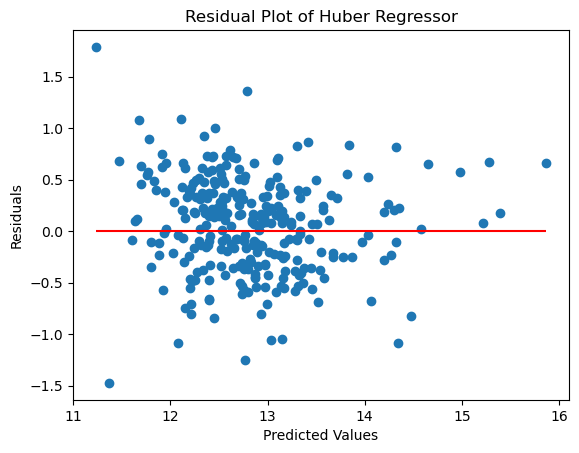

In [224]:
# Residual Plot
residuals = y_test - y_pred_huber
plt.scatter(y_pred_huber, residuals)
plt.hlines(y=0, xmin=min(y_pred_huber), xmax=max(y_pred_huber), color='red')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot of Huber Regressor')
plt.show()

**Residual Analysis**:

The residual plot shows a fairly random distribution with only minor signs of outliers, indicating that the Huber Regression model performs well.

## 8. Result & Evaluation

Based on the model comparison, the Huber Regression model demonstrated the best performance in predicting property prices. This section provides a comprehensive evaluation of the Huber Regression model, focusing on its assumptions, residual behavior, and feature impact on the real estate dataset.

#### 8.1 Multicolinearity

**Overview:**

Multicollinearity occurs when two or more independent variables in a regression model are highly correlated. This can lead to: 
- Redundant information in the model.
- Inflated standard errors for coefficients.
- Difficulty in interpreting the effect of individual variables.

**Findings:**

The heatmap of the correlation matrix reveals the following:
- **High correlation** between `sqft * kitchen_text` and `sqft * log_garage` suggests potential redundancy in these interaction terms.
- Other variables show **moderate to low correlations**, indicating that multicollinearity is generally manageable for most features.

**Next Steps:**

Addressing multicollinearity is crucial to maintaining accurate model predictions. As a next step, we could:
- Perform feature selection or dimensionality reduction techniques (e.g., LASSO, Ridge regression).
- Investigate the removal or transformation of highly correlated terms (`sqft * kitchen_text` and `sqft * log_garage`) to reduce redundancy.

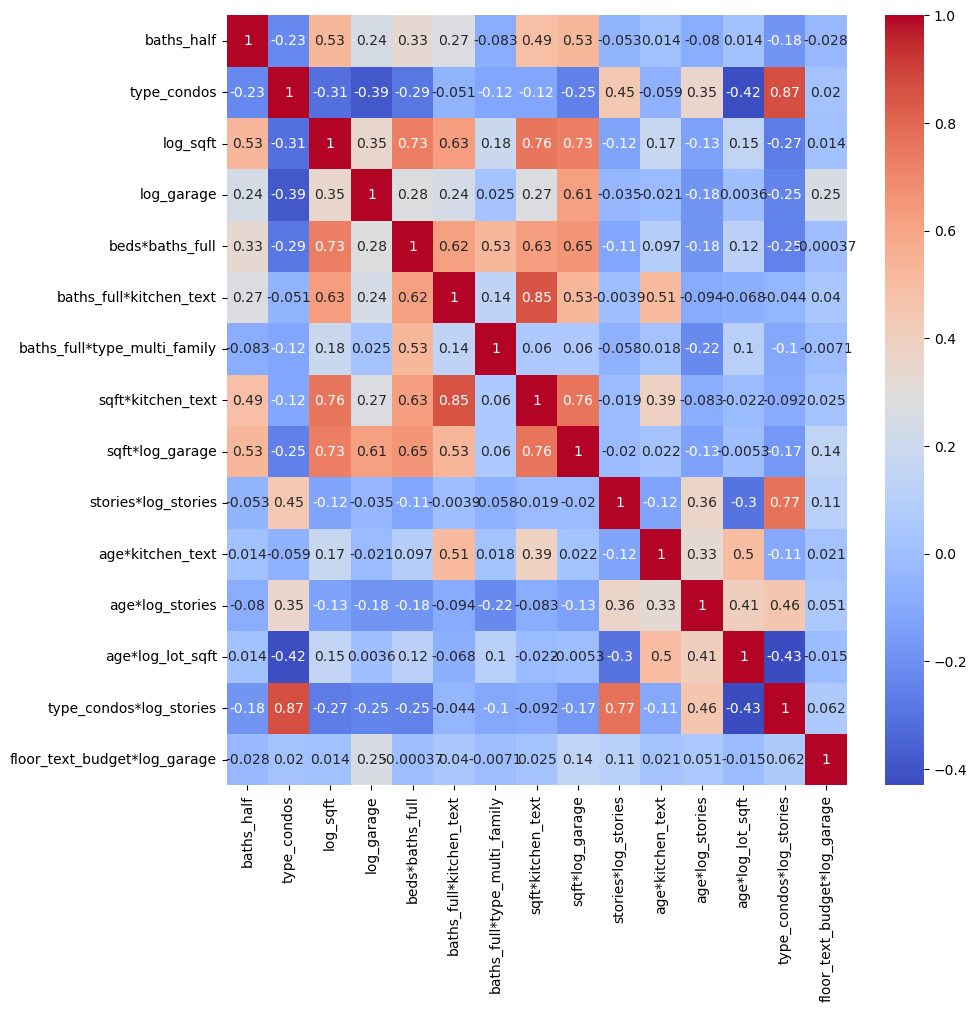

In [199]:
X_best = add_interaction_terms(X)[selected_features]
correlation_matrix = X_best.corr()
# print(correlation_matrix.iloc[1:, 1:])

# Visualize the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix.iloc[1:, 1:], annot=True, cmap='coolwarm')
# plt.savefig("plot.png", dpi=300, bbox_inches="tight")  # Saves as PNG with high resolution
plt.show()

#### 8.2 Feature Effect

This section evaluates the Huber Regression model's selected coefficients to identify how individual features impact property values. Positive coefficients indicate features that enhance value, while negative coefficients suggest features that may diminish value.

**Overview of Feature impact:**

- **Positive Coefficients**: `baths_full` exhibits the highest positive coefficient, which indicates that each additional full bathroom significantly increases property value.
- **Negative Coefficients**: Features like `type_condos * log_stories` have negative coefficients, suggesting diminishing returns on certain property features as they scale.

**Insights for Decision Making:**
Understanding the influence of specific features on property values will offer valuable guidance for stakeholders:
- **Property Enhancements**: Focus on features like adding full bathrooms to maximize property value.
- **Investment Strategies**: Prioritize property types and configurations with strong positive impacts while being cautious of diminishing returns from less impactful or negatively correlated features.

/var/folders/zr/hq5f8g3s0jq6yt_pl2ppbgmc0000gn/T/ipykernel_33315/291135629.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = "Coefficient", y = "Feature", data = coefficients, palette = "viridis")


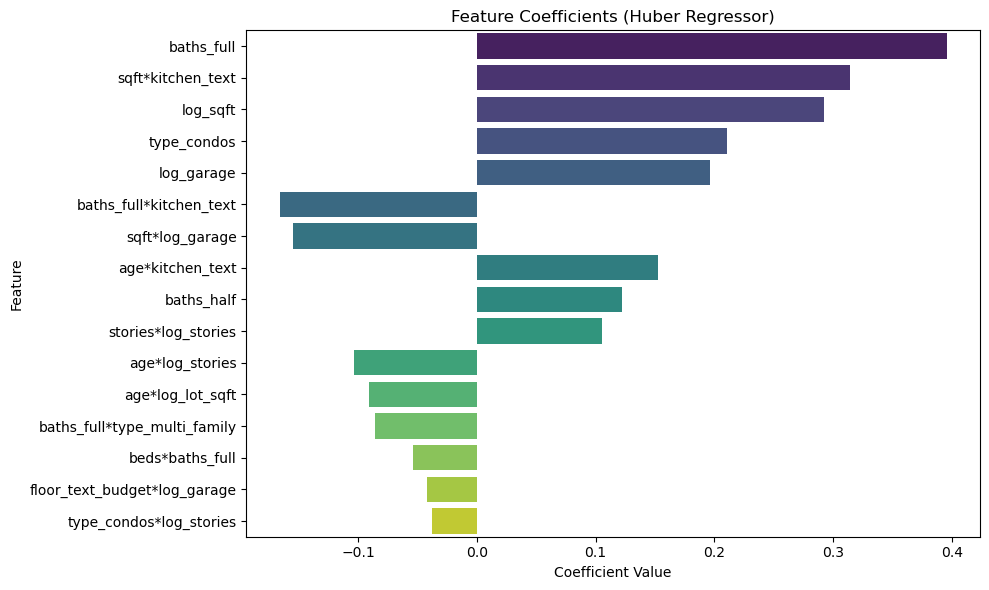

In [248]:
# Ensure the model has been fitted
if not hasattr(model_huber, "coef_"):
    raise AttributeError("The model must be fitted before accessing coefficients.")

# Combine selected features with coefficients
coefficients = pd.DataFrame({
    "Feature": selected_features,
    "Coefficient": model_huber.coef_,
})

# Sort by absolute value of coefficients (optional, if direction is not needed)
coefficients["AbsCoefficient"] = coefficients["Coefficient"].abs()
coefficients = coefficients.sort_values("AbsCoefficient", ascending = False)

# Plot the coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x = "Coefficient", y = "Feature", data = coefficients, palette = "viridis")
plt.title("Feature Coefficients (Huber Regressor)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

#### 8.3 Heteroskedasticity

Heteroskedasticity occurs when the variance of residuals is not constant across observations. This violates one of the key regression assumptions, which requires homoscedasticity (constant variance of errors). Testing for heteroskedasticity is crucial to ensure the reliability of model estimates.

In [252]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

X_train_sm = sm.add_constant(X_train_interactions[selected_features])
model_sm = sm.OLS(y_train.values, X_train_sm).fit()

# Step 2: Test for heteroskedasticity (Breusch-Pagan Test)
# The Breusch-Pagan test requires residuals and the design matrix.
bp_test = het_breuschpagan(model_sm.resid, model_sm.model.exog)
# bp_test returns: (Lagrange multiplier statistic, p-value, f-value, f p-value)
print("Breusch-Pagan test:")
print("LM statistic:", bp_test[0])
print("p-value:", bp_test[1])
print("F-statistic:", bp_test[2])
print("F-test p-value:", bp_test[3])

Breusch-Pagan test:
LM statistic: 76.50553688640619
p-value: 7.049062239768806e-10
F-statistic: 5.0454188659775365
F-test p-value: 3.138015465653184e-10


**Interpretation:**
Looking at the Breusch-Pagan test results, the p-values are very low, and the standard errors for the coefficients HC0, HC1, HC2, HAC are generally larger than the standard errors in the Standard OLS model. This leads to the rejection of the null hypothesis $H_0$ that there is no heteroskedasticity, and suggests potential heteroskedasticity in the model.

**Example: `baths_full` & `baths_half`**
- **Coefficients (Coef)**: Consistent across different methods of calculating robust standard errors (e.g., HC0, HC1, HC2, HAC). This consistency suggests that the estimated effects are stable despite heteroskedasticity.
- **P-values**: Low across all methods, which indicates statistical significance of the variables. (Reject the null hypothesis)

In [255]:
coefficients = selected_features
results_comparison = {}

for beta in coefficients:
    # Standard OLS results
    results_standard = model_sm.summary2().tables[1].loc[beta, ['Coef.', 'Std.Err.', 't', 'P>|t|']]

    # Heteroskedasticity-robust (HC) adjustments
    results_hc0 = model_sm.get_robustcov_results(cov_type='HC0').summary2().tables[1].loc[beta, ['Coef.', 'Std.Err.', 't', 'P>|t|']]
    results_hc1 = model_sm.get_robustcov_results(cov_type='HC1').summary2().tables[1].loc[beta, ['Coef.', 'Std.Err.', 't', 'P>|t|']]
    results_hc2 = model_sm.get_robustcov_results(cov_type='HC2').summary2().tables[1].loc[beta, ['Coef.', 'Std.Err.', 't', 'P>|t|']]
    results_hac = model_sm.get_robustcov_results(cov_type='HAC', maxlags=1).summary2().tables[1].loc[beta, ['Coef.', 'Std.Err.', 't', 'P>|t|']]

    # Combine results into a DataFrame for comparison
    results_comparison[beta] = pd.DataFrame({
        'Standard OLS': results_standard,
        'HC0': results_hc0,
        'HC1': results_hc1,
        'HC2': results_hc2,
        'HAC': results_hac
    }).T

results_comparison

{'baths_full':                  Coef.  Std.Err.         t         P>|t|
 Standard OLS  0.446026  0.048171  9.259147  9.944925e-20
 HC0           0.446026  0.056578  7.883377  7.419592e-15
 HC1           0.446026  0.056999  7.825146  1.152801e-14
 HC2           0.446026  0.059189  7.535676  9.879872e-14
 HAC           0.446026  0.056389  7.909763  6.071005e-15,
 'baths_half':                  Coef.  Std.Err.         t         P>|t|
 Standard OLS  0.128298  0.018120  7.080621  2.506998e-12
 HC0           0.128298  0.019582  6.551722  8.597950e-11
 HC1           0.128298  0.019728  6.503327  1.173828e-10
 HC2           0.128298  0.020100  6.383147  2.520741e-10
 HAC           0.128298  0.019910  6.443932  1.715271e-10,
 'type_condos':                  Coef.  Std.Err.         t         P>|t|
 Standard OLS  0.202643  0.042886  4.725211  2.585796e-06
 HC0           0.202643  0.040591  4.992330  6.897533e-07
 HC1           0.202643  0.040893  4.955454  8.309769e-07
 HC2           0.202643  0.

#### 8.4 Normality

Normality of residuals is one of the key assumptions of linear regression models. Normal residuals ensure that hypothesis tests (e.g., t-tests, F-tests) and confidence intervals are valid. Moreover, the regression model is likely to provide unbiased and reliable estimates if residuals are normally distributed.

**Test Results:**
Four statistical tests were conducted to assess the normality of residuals:

1. Shapiro-Wilk Test
2. Kolmogorov-Smirnov Test
3. D’Agostino’s K-squared Test
4. Jarque-Bera Test

All tests reject the null hypothesis $H_0$ of normality with small p-values, suggesting that the residuals are not normally distributed.

In [268]:
import statsmodels.api as sm
from scipy.stats import norm, levy_stable
from scipy.stats import shapiro, kstest, anderson, normaltest, jarque_bera

residuals = y_train - model_huber.predict(X_train_interactions[selected_features])
test_results = []
# Shapiro-Wilk Test
stat, p_value = shapiro(residuals)
test_results.append({
    "Test Name": "Shapiro-Wilk Test",
    "Equation": r"Shapiro-Wilk statistic",
    "Statistic": stat,
    "p-value": p_value,
    "Decision": "Reject H0" if p_value < 0.05 else "Fail to Reject H0"
})

# Kolmogorov-Smirnov Test (against normal distribution)
stat, p_value = kstest(residuals, 'norm', args=(np.mean(residuals), np.std(residuals, ddof=1)))
test_results.append({
    "Test Name": "Kolmogorov-Smirnov Test",
    "Equation": r"KS statistic",
    "Statistic": stat,
    "p-value": p_value,
    "Decision": "Reject H0" if p_value < 0.05 else "Fail to Reject H0"
})

# D’Agostino’s K-squared Test
stat, p_value = normaltest(residuals)
test_results.append({
    "Test Name": "D’Agostino’s K-squared Test",
    "Equation": r"K-squared statistic",
    "Statistic": stat,
    "p-value": p_value,
    "Decision": "Reject H0" if p_value < 0.05 else "Fail to Reject H0"
})

# Jarque-Bera Test
stat, p_value = jarque_bera(residuals)
test_results.append({
    "Test Name": "Jarque-Bera Test",
    "Equation": r"JB statistic",
    "Statistic": stat,
    "p-value": p_value,
    "Decision": "Reject H0" if p_value < 0.05 else "Fail to Reject H0"
})

print(pd.DataFrame(test_results))

                     Test Name                Equation   Statistic  \
0            Shapiro-Wilk Test  Shapiro-Wilk statistic    0.969628   
1      Kolmogorov-Smirnov Test            KS statistic    0.060725   
2  D’Agostino’s K-squared Test     K-squared statistic  131.772680   
3             Jarque-Bera Test            JB statistic  245.501590   

        p-value   Decision  
0  7.860802e-15  Reject H0  
1  3.817235e-04  Reject H0  
2  2.431791e-29  Reject H0  
3  4.897867e-54  Reject H0  


**Visualization:**

- **Histogram with Fits:**
    - The histogram displays the residual distribution alongside fitted normal and stable distribution curves. The observed residuals deviate from normality, particularly in the tails.
    - The stable distribution appears to fit the data slightly better, suggesting that the residuals might exhibit heavy-tailed behavior or skewness.
- **QQ Plot**: The QQ plot highlights heavier-than-expected tails, providing further evidence of deviation from normality. This is particularly noticeable in the points that deviate from the reference line at the ends.

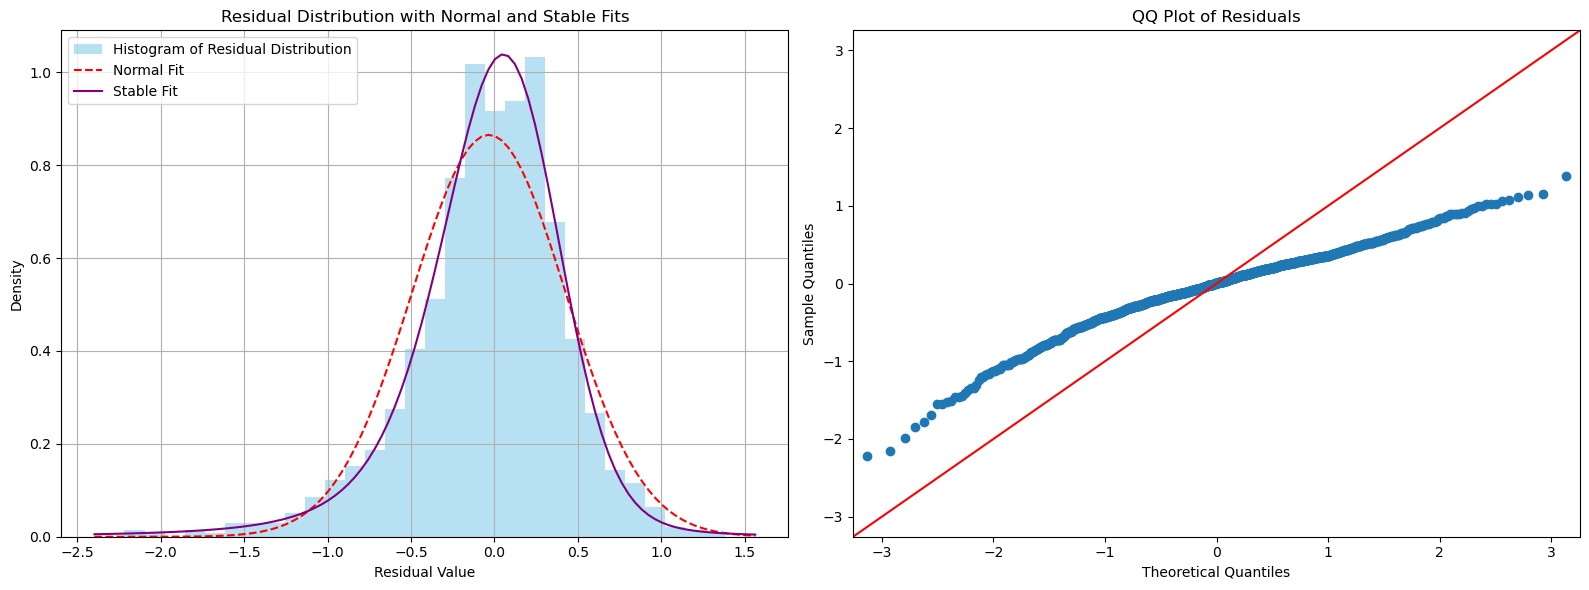

In [270]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Histogram of the residuals with normal and stable fits
axs[0].hist(residuals, bins=30, density=True, alpha=0.6, color='skyblue', label='Histogram of Residual Distribution')

# Normal fit on the histogram
mu, std = norm.fit(residuals)
xmin, xmax = axs[0].get_xlim()
x_values = np.linspace(xmin, xmax, 100)
p_norm = norm.pdf(x_values, mu, std)
axs[0].plot(x_values, p_norm, 'r--', label='Normal Fit')

# Stable fit on the histogram
alpha_hat, beta_hat, loc_hat, scale_hat = levy_stable._fitstart(residuals)
p_stable = levy_stable.pdf(x_values, alpha_hat, beta_hat, loc=loc_hat, scale=scale_hat)
axs[0].plot(x_values, p_stable, 'purple', linestyle='-', label='Stable Fit')

axs[0].set_xlabel("Residual Value")
axs[0].set_ylabel("Density")
axs[0].set_title("Residual Distribution with Normal and Stable Fits")
axs[0].legend()
axs[0].grid(True)

# QQ plot of the residuals
axs[1].set_title("QQ Plot of Residuals")
sm.qqplot(residuals, line='45', ax=axs[1])

# Display the plots
plt.tight_layout()
plt.show()

Distributions with heavier tails have a higher likelihood of producing extreme observations. In modeling terms, this suggests that using a stable distribution (or another heavy-tailed model) might be more appropriate for capturing the behavior of these residuals than a normal distribution.

## 9. Conclusion and Future Works

#### 9.1 Conclusion:
This project successfully analyzed housing data to develop a robust predictive model for property prices. The following key steps and achievements were accomplished:

---

1. **Data Preprocessing and Feature Engineering**:
   - Addressed missing values and transformed relevant variables to improve model input quality.
   - Created binary dummy variables and interaction terms to capture key property features and their interactions.
   
---

2. **Model Selection and Evaluation**:
   - Compared a baseline Ordinary Linear Regression (OLS) model without any preprocessing to advanced models like Lasso, Ridge, and Huber Regression.
   - The **Baseline OLS Regression model** (no preprocessing) achieved:
     - Mean Squared Error (MSE): **623,761,136,340.02**
     - Mean Absolute Error (MAE): **380,299.01**
     - $R^2$: **0.5618**
     - Adjusted $R^2$: **0.5477**
   - After implementing feature engineering, text-data mapping, and robust regression techniques, the **Huber Regression model** significantly improved performance:
     - MSE: Reduced by **99.99%** to **0.2631**.
     - MAE: Reduced by **99.90%** to **0.3928**.
     - $R^2$: Improved by **33.18%**, from **0.5618** to **0.7478**.
     - Adjusted $R^2$: Improved by **32.71%**, from **0.5477** to **0.7264**.

---

3. **Diagnostic Evaluation**:
   - Performed detailed evaluations of model assumptions, including multicollinearity, heteroskedasticity, and residual normality.
   - Adjusted for identified issues (e.g., using robust standard errors for heteroskedasticity) to ensure reliable and interpretable results.

--- 

4. **Feature Impact Analysis**:
   - Assessed the effects of key features, such as `baths_full`, which showed the most significant positive impact on property value.
   - Highlighted features with negative coefficients, indicating diminishing returns for specific property attributes.

--- 

#### 9.2 Future Works:
This project provides a solid foundation but leaves room for further improvements and exploration:

1. **Enhanced Feature Engineering**: Incorporate external datasets, such as neighborhood crime rates, school ratings, or proximity to amenities, to improve the explanatory power of the model. Explore advanced feature selection techniques to refine the input variables further.

2. **Addressing Heavy-Tailed Residuals**: Apply a **GAMLSS model** with a **t-distribution (TF)** to address the **heavy tail** issue further.

3. **Exploring Non-Linear Relationships**: Explore more complex non-linear relationships among the features, beyond log transformations and second-order interactions, to capture deeper patterns in the data.

4. **Residual Analysis**: Investigate the sources of non-normality in residuals and experiment with data transformations or alternative loss functions to address these issues.